In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from utils import lowpass, welch

In [21]:
def animate_constellation(signal, step_size):
    from matplotlib.animation import FuncAnimation

    fig, ax = plt.subplots()
    xdata, ydata = [], []
    ln, = ax.plot([], [], '.')

    def init():
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
        return ln,

    def update(frame):
        ln.set_data(np.real(frame), np.imag(frame))
        return ln,
    
    frames = [signal[i:i + step_size] for i in range(0, len(signal) - step_size, step_size)]
    return FuncAnimation(fig, update, frames=frames, init_func=init, blit=True)

def plot_iq(iq_signal):
    fig, ax = plt.subplots()
    fig.set_size_inches((20, 10))
    ax.plot(np.real(iq_signal))
    ax.plot(np.imag(iq_signal))

### **BPSK**

In [4]:
T_total = 1  # seconds
f_carrier = 57000  # Hertz (RDS carrier frequency)
f_symbol = f_carrier / 48  # 1187.5 Hz (RDS symbol frequency)
f_sampling = 2 *171000  # gotta be > 2 * f_carrier

N = T_total * f_sampling
t_s = np.linspace(0, 1, N)
samples_per_symbol = int(f_sampling / f_symbol)

In [5]:
message = """No siema, witajcie w mojej kuchni. Dzisiaj ugotujemy coś RDSowego."""
message_bits = np.unpackbits(np.frombuffer(message.encode('utf-8'), dtype=np.uint8))
message_signal = np.repeat(message_bits, samples_per_symbol)
message_signal_padded = np.pad(message_signal, (0, N - len(message_signal)), mode='constant')

Bi-phase shift keying approach: $$y_i = sin(2 \pi f t_i + \phi_i), \ \phi_i \in \{ 0, \pi\}$$

Quadrature amplitude modulation approach: $$y_i = m_i sin(2 \pi f t_i), \ m_i \in \{ -1, 1 \}$$

They're both equivalent.

In [6]:
signal_bpsk = np.sin(2 * np.pi * f_carrier * t_s + np.pi * message_signal_padded)

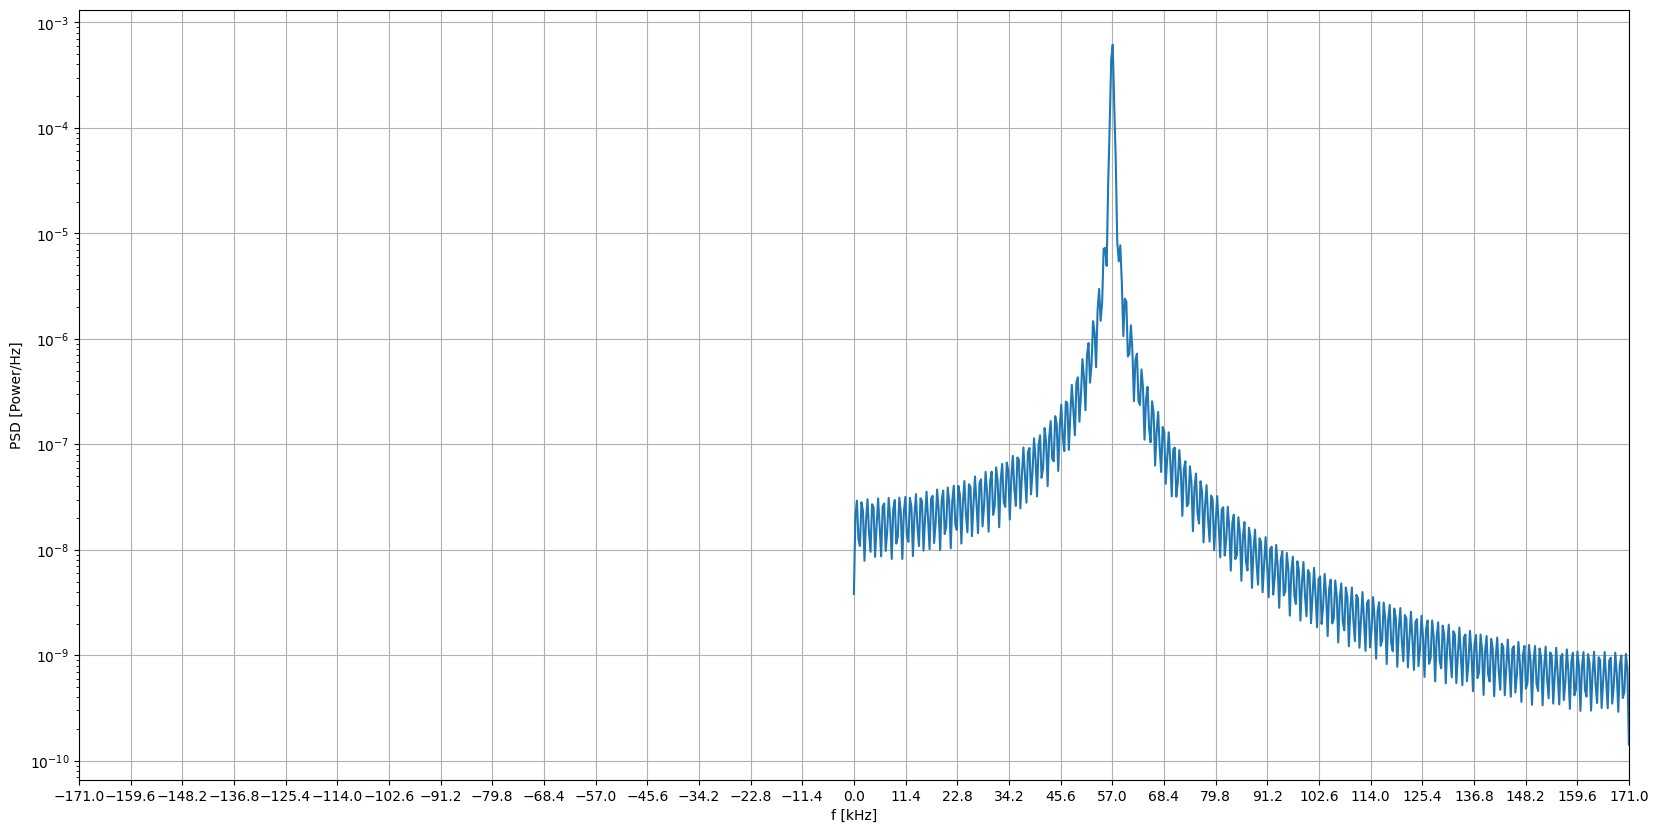

In [7]:
welch(signal_bpsk, f_sampling)

Not plotting time domain signal because there's a lot of samples per single symbol so there's little variation.

**Demodulation**

Question: do we need higher sampling rate so that we can filter out high-frequency components when producing $I(t)$ and $Q)t)$ signals?

In [8]:
i_signal_pre_lpf = signal_bpsk * np.sin(2 * np.pi * f_carrier * t_s)
q_signal_pre_lpf = signal_bpsk * np.cos(2 * np.pi * f_carrier * t_s)

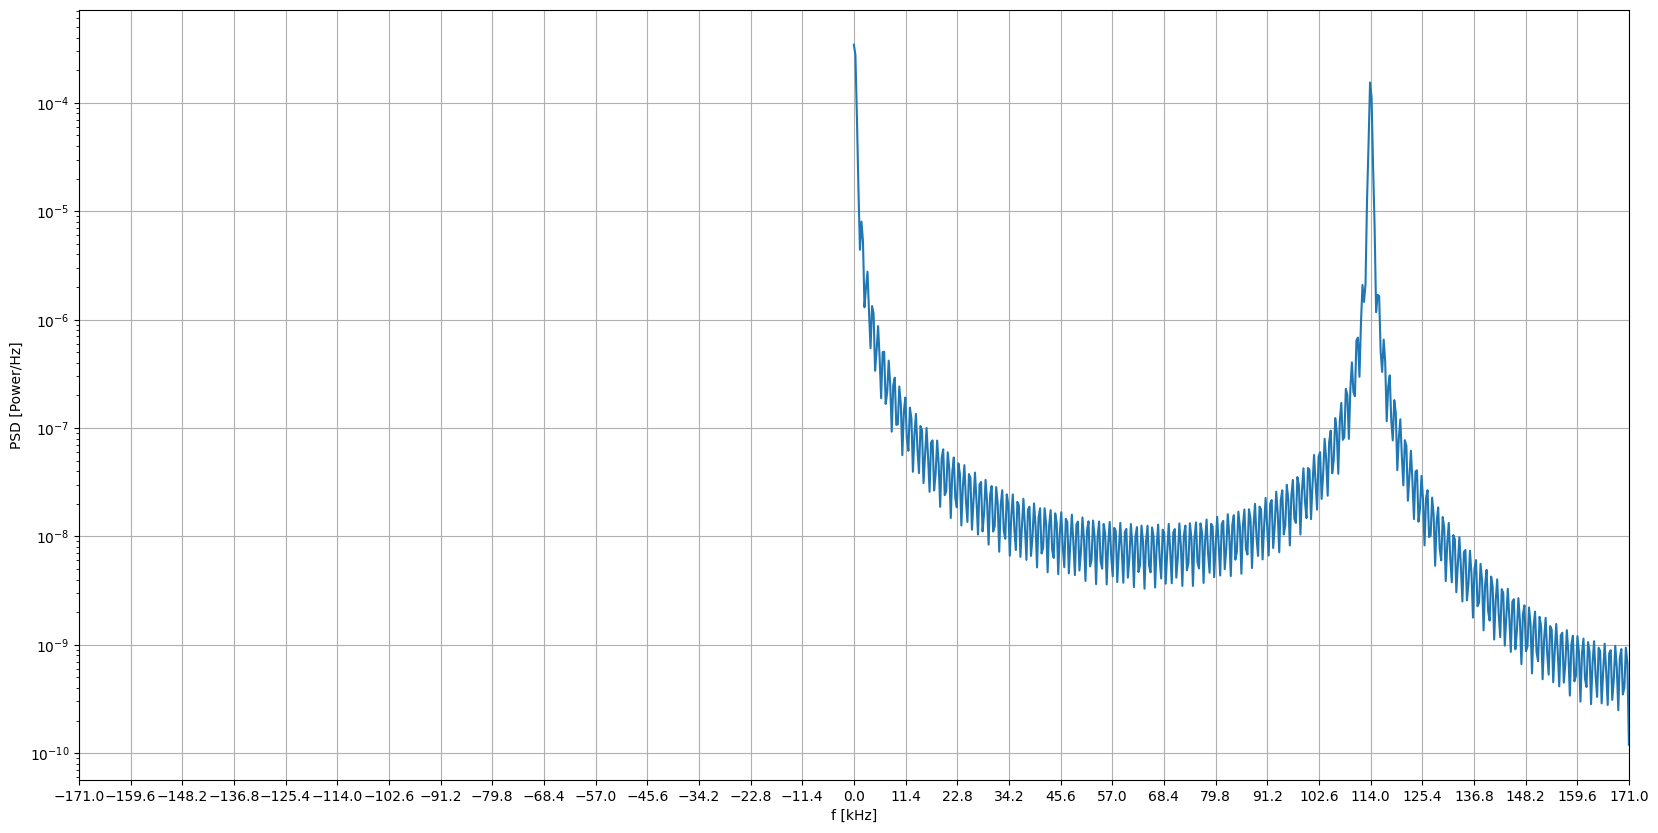

In [9]:
welch(i_signal_pre_lpf, f_sampling)

In [10]:
# 1187.5 Hz is the symbol frequency
i_signal = lowpass(i_signal_pre_lpf, f_sampling, 10000)
q_signal = lowpass(q_signal_pre_lpf, f_sampling, 10000)

Original $I(t)$ signal equals 1 for bit input 0 and equals -1 for bit input 1. Here we have it times 0.5  because sum of cosines.

Original $Q(t)$ signal is 0.

[0 1 0 0 1 1 1 0 0 1]


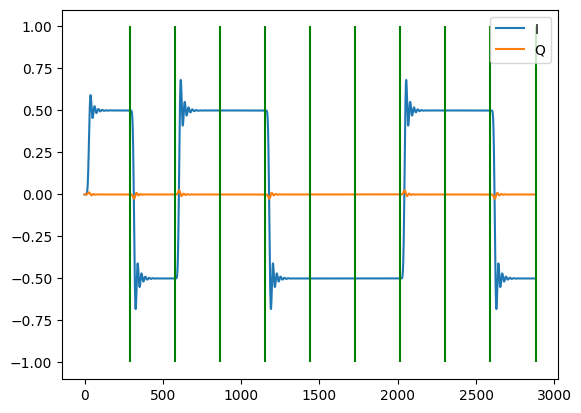

In [11]:
lookup_symbols = 10
print(message_bits[:10])
lookup_samples = int(lookup_symbols * samples_per_symbol)
plt.plot(i_signal[:lookup_samples], label='I')
plt.plot(q_signal[:lookup_samples], label='Q')
plt.legend()
plt.vlines(np.arange(1, lookup_symbols + 1) * samples_per_symbol, -1, 1, color='green');

**Mueller and Muller timing recovery**

In [41]:
def mm_recover_symbols(signal, to_symbol, samples_per_symbol, alpha=0.3):
    # steps:
    #  - sample the signal using estimated delta_t
    #  - update delta_t
    sample_indexes = [0]
    samples = [signal[0]]
    symbols = [to_symbol(samples[0])]
    deltas = []
    i, delta_t = 1, 0
    
    while i < len(signal):
        sample_indexes.append(i)
        samples.append(signal[i])
        symbols.append(to_symbol(signal[i]))
        
        mm_delta = np.real(samples[-1] * np.conj(symbols[-2]) - samples[-2] * np.conj(symbols[-1]))
        delta_t += alpha * mm_delta
        deltas.append(delta_t)
        
        i += samples_per_symbol + int(delta_t)
        delta_t -= int(delta_t)
    
    return np.array(sample_indexes[1:]), np.array(symbols[1:]), np.array(deltas)


def to_bpsk_symbol(sample):
    return 2 * int(np.real(sample) < 0) - 1 + 1j * 0  # return 0 for phase ~= 0 and 1 for phase ~= PI

Without offset it should just work.

In [13]:
iq_signal = i_signal + 1j * q_signal
indexes, symbols, _ = mm_recover_symbols(iq_signal, to_bpsk_symbol, samples_per_symbol)

/home/kuba/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


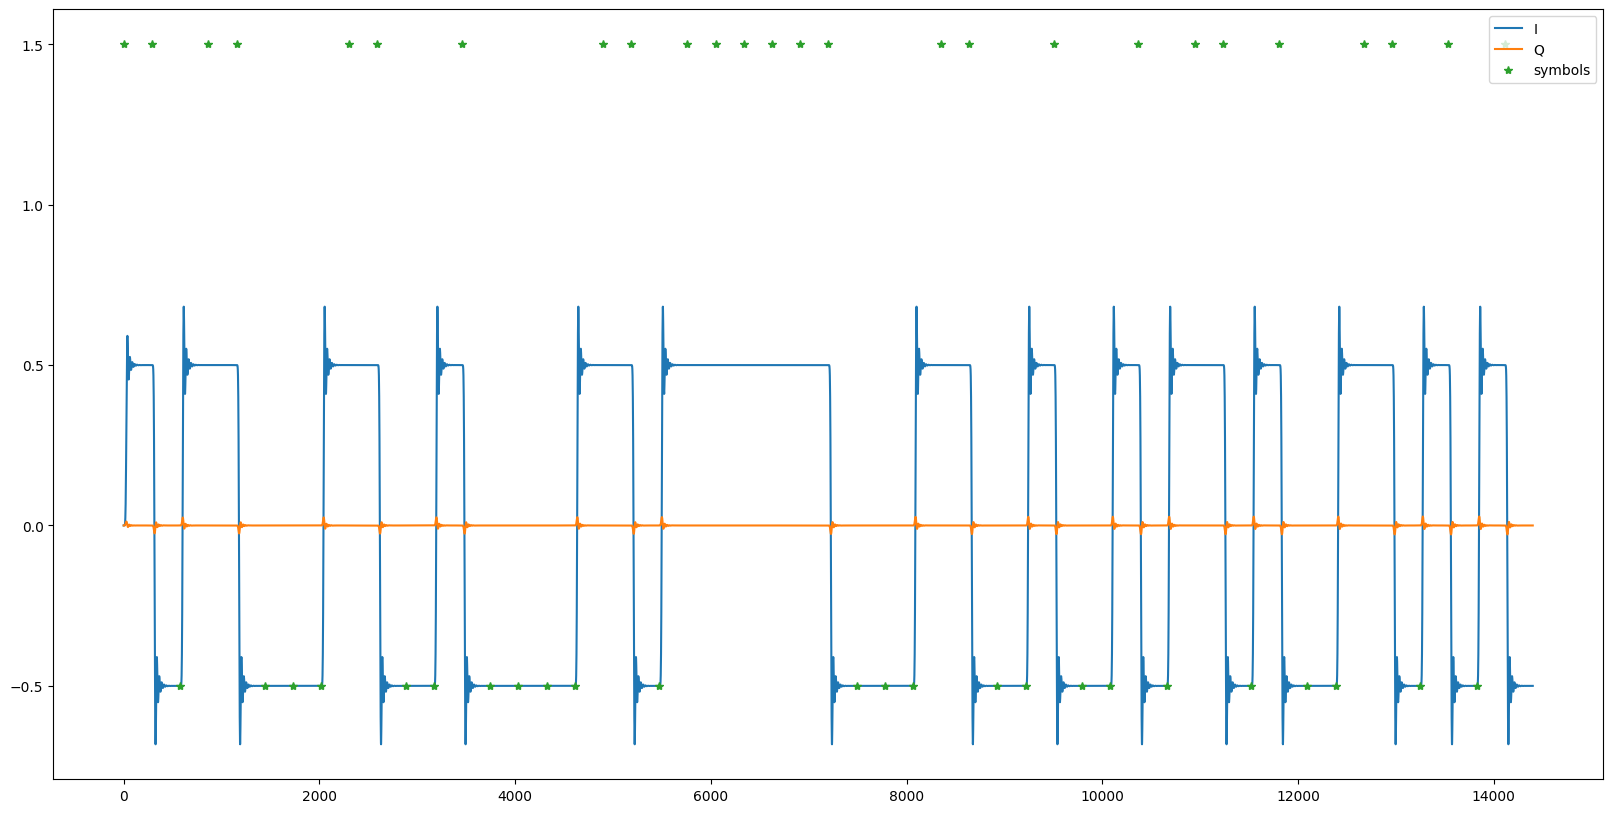

In [14]:
lookup_symbols = 50
lookup_samples = int(lookup_symbols * samples_per_symbol)

plt.figure(figsize=(20, 10))
plt.plot(i_signal[:lookup_samples], label='I')
plt.plot(q_signal[:lookup_samples], label='Q')
plt.plot(indexes[:lookup_symbols], 0.5 - symbols[:lookup_symbols], '*', label='symbols')
plt.legend();

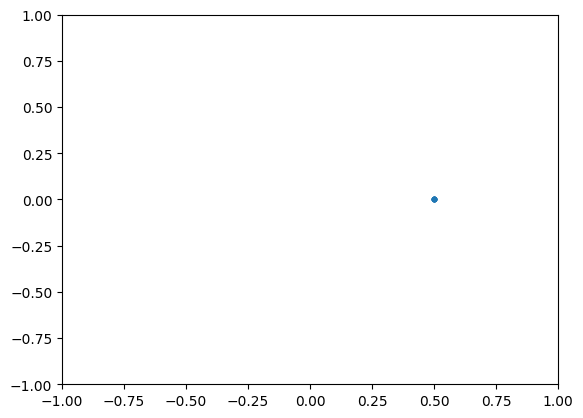

In [15]:
symbol_samples = iq_signal[indexes]
ani = animate_constellation(symbol_samples, 10)
HTML(ani.to_html5_video())

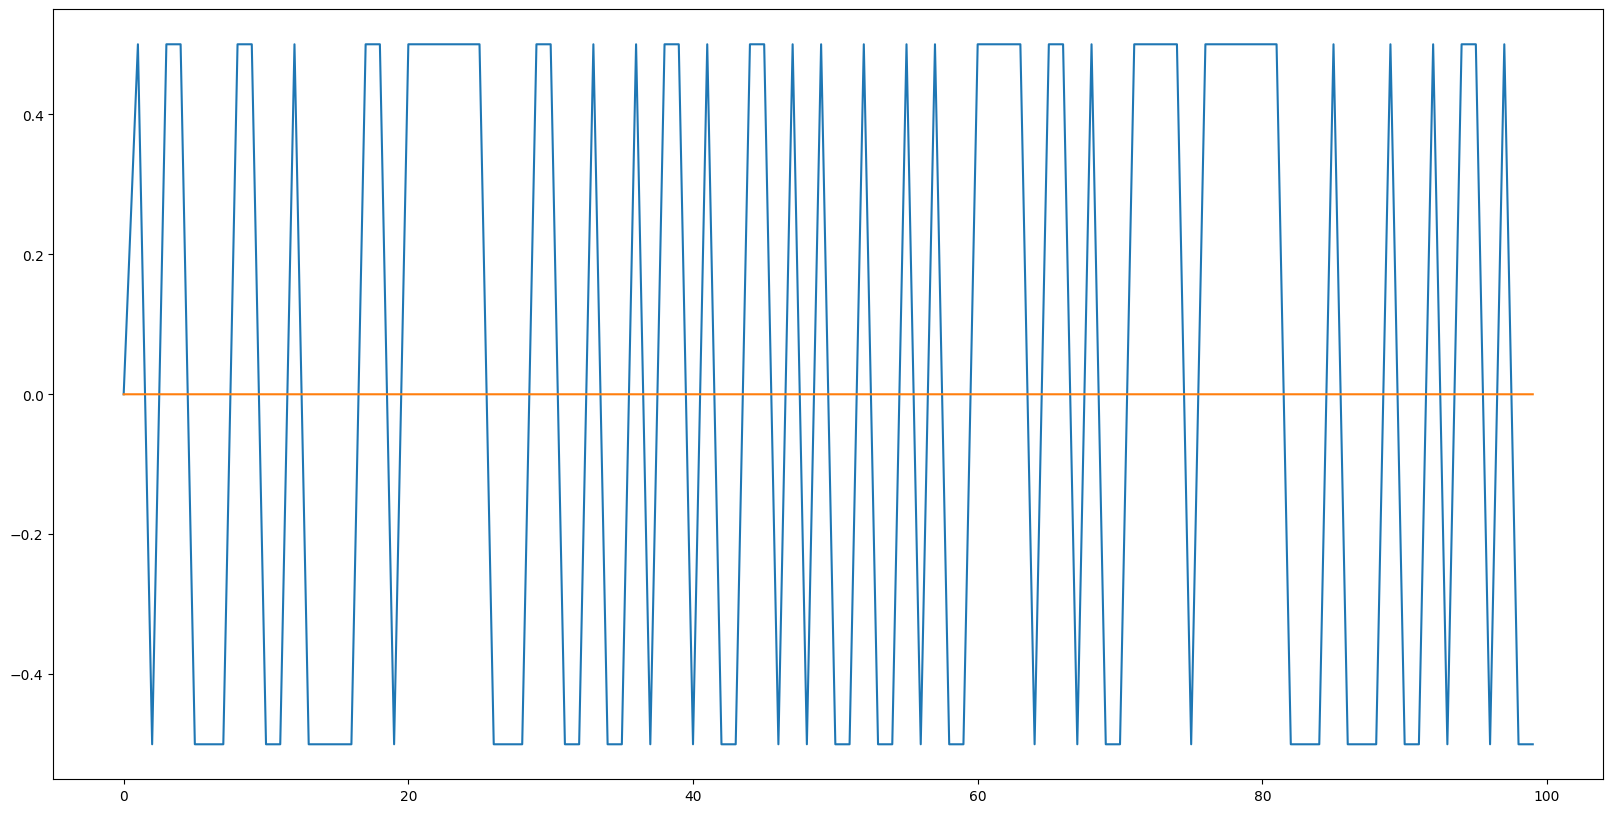

In [23]:
plot_iq(symbol_samples[:100])

**M&M timing recovery with phase and frequency offset**

Phase offset could be applied by convolution with phase-shifted *sinc* function.

In [16]:
def mk_iq_signal(input_signal, t_s, f_carrier, f_symbol, f_sampling, lp_offset=5000):
    i_signal_pre_lpf = input_signal * np.sin(2 * np.pi * f_carrier * t_s)
    q_signal_pre_lpf = input_signal * np.cos(2 * np.pi * f_carrier * t_s)
    i_signal = lowpass(i_signal_pre_lpf, f_sampling, f_symbol + lp_offset)
    q_signal = lowpass(q_signal_pre_lpf, f_sampling, f_symbol + lp_offset)
    return i_signal + 1j * q_signal

In [24]:
f_offset = 10  # PySDR choice
phase_offset = int(0.4 * samples_per_symbol)  # shift by 0.4 of a symbol

signal_bpsk_offset = np.sin(2 * np.pi * (f_carrier + f_offset) * t_s + np.pi * message_signal_padded)[phase_offset:]

In [42]:
iq_offset_signal = mk_iq_signal(signal_bpsk_offset, t_s[phase_offset:], f_carrier, f_symbol, f_sampling)
offset_indexes, _, deltas = mm_recover_symbols(iq_offset_signal, to_bpsk_symbol, samples_per_symbol)
offset_symbol_samples = iq_offset_signal[offset_indexes]

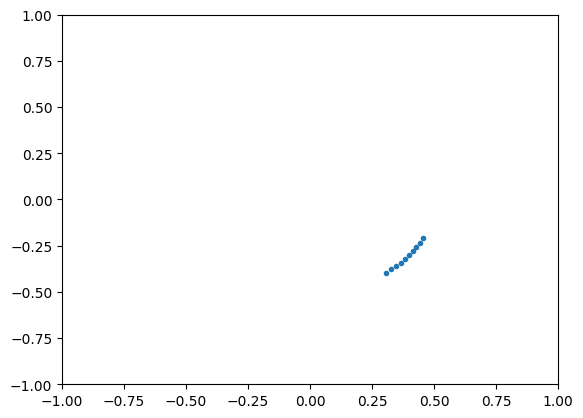

In [29]:
ani2 = animate_constellation(offset_symbol_samples, 10)
HTML(ani2.to_html5_video())

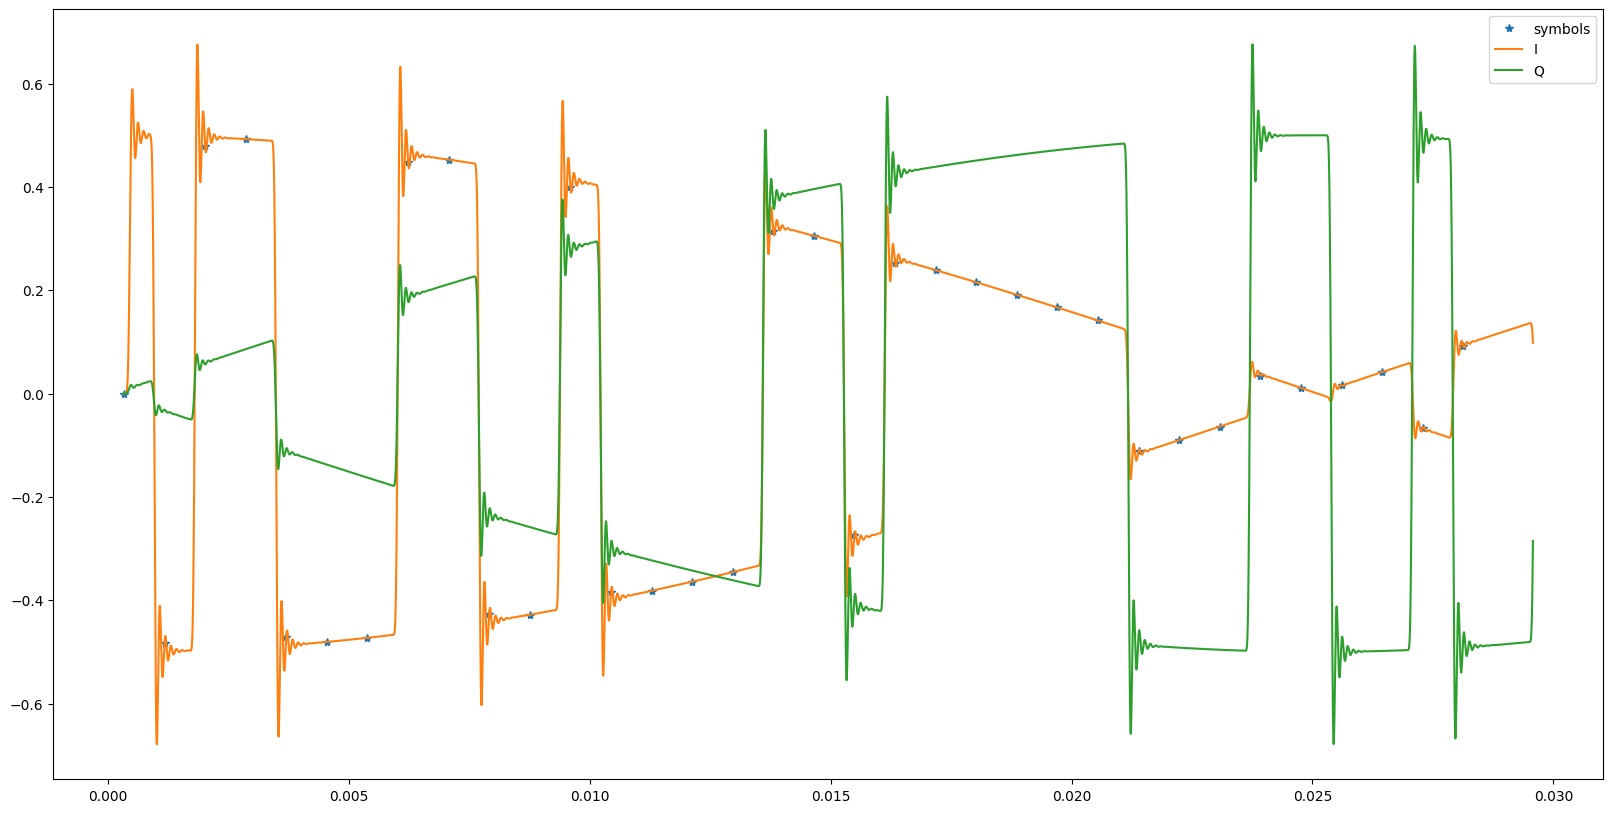

In [65]:
cut = 10000
plt.figure(figsize=(20, 10))
plt.plot(t_s[phase_offset:][offset_indexes][:cut // samples_per_symbol], np.real(iq_offset_signal[offset_indexes])[:cut // samples_per_symbol], '*', label='symbols')
plt.plot(t_s[phase_offset:][:cut], np.real(iq_offset_signal[:cut]), label='I')
plt.plot(t_s[phase_offset:][:cut], np.imag(iq_offset_signal[:cut]), label='Q')
plt.legend();

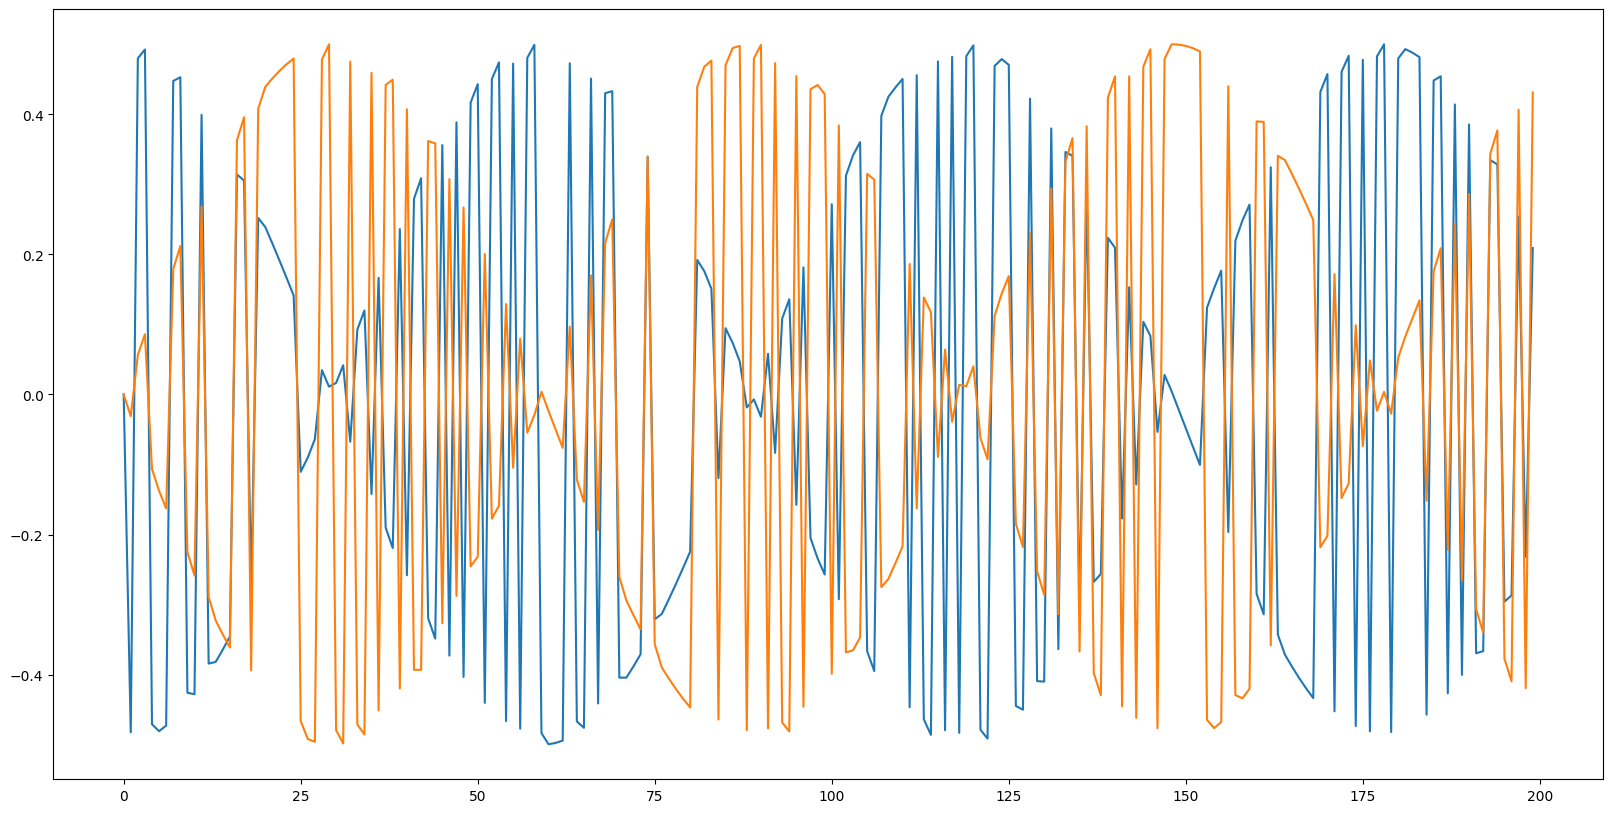

In [30]:
plot_iq(offset_symbol_samples[:200])

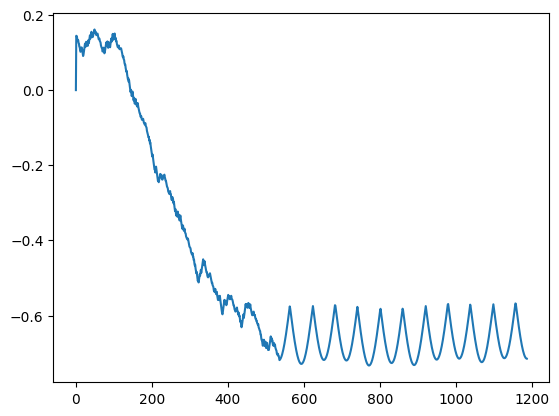

In [33]:
plt.plot(deltas);

I have a theory that deltas do absolutely nothing mainly because I and Q signals are flat (no pulse shaping) so actually wherever we sample it's ok.

### **TODOs**
 0. Tooling! What I want to do here:
    - bit sequence on input
    - map bits to symbols -> gotta plot IQ signal real & imaginary (allow window choice)
    - pulse shaping -> gotta plot the result together with input bits
    - BPSK modulation + optional frequency, phase offset, white noise -> plot spectrum (notice SNR)
    - BPSK demodulation - obtain back the IQ signal (Costas loop here?) (plot it again, with loop and without) (plot phase & frequency estimate from Costas loop)
    - M&M timing recovery -> plot input signal together with sample locations (allow window choice), animate constellation
    - finally map samples to symbols and back to input bits 
    
 1. Figure out what *sinc* filter shift does (how many samples shift after 16x oversample).
 2. Apply matched pulse filtering and see how it affects received I and Q signals. Then apply clock recovery to pulse shaped symbols.
 3. Apply frequency and phase offsets to mess up symbol recovery.
 4. Apply Costas loop to mitigate these offsets.